In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from xgboost import XGBClassifier

In [2]:
X_train = pd.read_csv('data/X_train.csv', index_col='id')
X_test = pd.read_csv('data/X_test.csv', index_col='id')
y_train = pd.read_csv('data/y_train.csv', index_col='id')
y_test = pd.read_csv('data/y_test.csv', index_col='id')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40095 entries, 58975 to 23269
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         40095 non-null  int64  
 1   installer          40095 non-null  object 
 2   longitude          40095 non-null  float64
 3   latitude           40095 non-null  float64
 4   num_private        40095 non-null  int64  
 5   basin              40095 non-null  object 
 6   region             40095 non-null  object 
 7   region_code        40095 non-null  int64  
 8   district_code      40095 non-null  int64  
 9   population         40095 non-null  int64  
 10  public_meeting     40095 non-null  object 
 11  scheme_management  40095 non-null  object 
 12  permit             40095 non-null  object 
 13  construction_year  40095 non-null  int64  
 14  extraction_type    40095 non-null  object 
 15  management         40095 non-null  object 
 16  payment           

In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13365 entries, 33770 to 7443
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         13365 non-null  int64  
 1   installer          13365 non-null  object 
 2   longitude          13365 non-null  float64
 3   latitude           13365 non-null  float64
 4   num_private        13365 non-null  int64  
 5   basin              13365 non-null  object 
 6   region             13365 non-null  object 
 7   region_code        13365 non-null  int64  
 8   district_code      13365 non-null  int64  
 9   population         13365 non-null  int64  
 10  public_meeting     13365 non-null  object 
 11  scheme_management  13365 non-null  object 
 12  permit             13365 non-null  object 
 13  construction_year  13365 non-null  int64  
 14  extraction_type    13365 non-null  object 
 15  management         13365 non-null  object 
 16  payment            

In [5]:
y_train.value_counts(normalize=True)

status_group           
functional                 0.543609
non functional             0.383589
functional needs repair    0.072802
dtype: float64

In [6]:
y_test.value_counts(normalize=True)

status_group           
functional                 0.543659
non functional             0.383539
functional needs repair    0.072802
dtype: float64

The target is imbalanced, so we will be using SMOTE in the pipeline to resample the training data.

In [7]:
y_train = y_train.status_group

In [8]:
y_test = y_test.status_group

Create a function to calculate log-loss.

In [9]:
def log_loss(model, X=X_train, y=y_train, scoring='neg_log_loss', cv=3):
    log_loss = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    log_loss = -log_loss.mean()
    print(f'Log loss: {log_loss}')

Create a function to calculate model predictions.

In [10]:
def model_predictions(model, X=X_test, y=y_test):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    func = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    func_nr = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    non_func = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print(f'The model correctly predicts {round(func*100, 2)}% of the funtional wells.')
    print(f'The model correctly predicts {round(func_nr*100, 2)}% of the funtional-needs-repair wells.')
    print(f'The model correctly predicts {round(non_func*100, 2)}% of the non-functional wells.')

# XGBoost

In [12]:
X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64', 'int64'])

cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
num_pipe = Pipeline([('ss', StandardScaler())])

transformer = ColumnTransformer([('categorical', cat_pipe, X_train_cat.columns), 
                                  ('numerical', num_pipe, X_train_num.columns)])

In [13]:
xgboost_pipe = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('xgboost', XGBClassifier(n_jobs=-1, verbosity=2, random_state=42))
])
xgboost_pipe.fit(X_train, y_train)

[15:01:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:01:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:01:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:01:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[15:01:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:01:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 ext

[15:01:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:01:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:01:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:01:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:01:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:01:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra no

[15:02:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:02:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:02:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:02:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:02:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:02:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nod

[15:02:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:02:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:02:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:02:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:02:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:02:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra no

[15:02:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:02:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:02:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:02:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:02:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[15:02:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nod

[15:03:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:03:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:03:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:03:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:03:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:03:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nod

[15:03:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:03:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:03:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:03:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[15:03:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:03:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra n

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('num...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                          

In [16]:
print('Accuracy Score Train:', xgboost_pipe.score(X_train,y_train))
print('Accuracy Score Test:', xgboost_pipe.score(X_test,y_test))

Accuracy Score Train: 0.8091033794737499
Accuracy Score Test: 0.7627384960718294


In [17]:
log_loss(xgboost_pipe, X_train, y_train)

[15:05:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:05:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:05:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:05:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[15:05:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[15:05:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extr

[15:05:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:05:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:05:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:05:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[15:05:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:05:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra no

[15:06:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:06:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:06:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:06:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:06:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:06:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nod

[15:06:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:06:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:06:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:06:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:06:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:06:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nod

[15:06:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:06:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:06:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:06:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[15:06:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:06:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nod

[15:07:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:07:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:07:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:07:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:07:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:07:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nod

[15:07:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[15:07:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:07:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:07:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:07:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:07:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra no

[15:07:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:07:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:07:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:07:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:07:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:07:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra n

[15:08:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[15:08:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:08:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:08:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:08:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:08:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nod

[15:08:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:08:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:08:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:08:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[15:08:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:08:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra no

[15:09:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:09:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[15:09:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[15:09:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:09:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:09:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra no

[15:09:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:09:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:09:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nod

[15:09:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:09:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:09:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:09:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:09:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:09:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nod

[15:10:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:10:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:10:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:10:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:10:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:10:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra 

[15:10:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:10:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:10:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:10:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:10:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:10:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra no

[15:10:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:10:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:10:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[15:10:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:10:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:10:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nod

[15:11:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:11:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:11:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:11:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:11:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:11:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra no

[15:11:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[15:11:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[15:11:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[15:11:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[15:11:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:11:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nod

[15:11:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:11:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:11:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:11:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:11:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:11:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra no

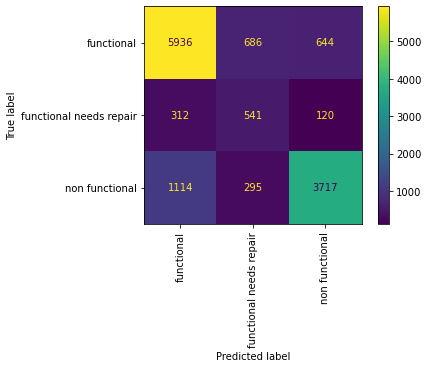

In [18]:
plot_confusion_matrix(xgboost_pipe, X_test, y_test, xticks_rotation='vertical');

In [19]:
model_predictions(xgboost_pipe, X_test, y_test)

The model correctly predicts 81.7% of the funtional wells.
The model correctly predicts 55.6% of the funtional-needs-repair wells.
The model correctly predicts 72.51% of the non-functional wells.


# XGBoost model 2 (max_depth=10)

In [27]:
xgboost_pipe_2 = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('xgboost', XGBClassifier(max_depth=10, n_jobs=-1, verbosity=2, random_state=42))
])
xgboost_pipe_2.fit(X_train, y_train)

[15:44:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 570 extra nodes, 0 pruned nodes, max_depth=10
[15:44:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[15:44:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[15:44:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 602 extra nodes, 0 pruned nodes, max_depth=10
[15:44:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 632 extra nodes, 0 pruned nodes, max_depth=10
[15:44:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56

[15:44:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 584 extra nodes, 0 pruned nodes, max_depth=10
[15:45:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=10
[15:45:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=10
[15:45:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[15:45:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[15:45:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 40

[15:45:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[15:45:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=10
[15:45:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[15:45:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[15:45:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[15:45:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 35

[15:46:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[15:46:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=10
[15:46:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[15:46:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[15:46:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=10
[15:46:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 29

[15:47:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[15:47:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[15:47:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[15:47:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[15:47:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[15:47:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 276

[15:48:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=10
[15:48:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[15:48:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=10
[15:48:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[15:48:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[15:48:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 202 

[15:48:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[15:48:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[15:49:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[15:49:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=10
[15:49:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=10
[15:49:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 16

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('num...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=1, missing=nan,
                         

In [28]:
print('Accuracy Score Train:', xgboost_pipe_2.score(X_train,y_train))
print('Accuracy Score Test:', xgboost_pipe_2.score(X_test,y_test))

Accuracy Score Train: 0.9138545953360768
Accuracy Score Test: 0.7851851851851852


In [29]:
model_predictions(xgboost_pipe_2, X_test, y_test)

The model correctly predicts 83.53% of the funtional wells.
The model correctly predicts 49.74% of the funtional-needs-repair wells.
The model correctly predicts 76.88% of the non-functional wells.


# XGBoost Model 3

In [33]:
xgboost_pipe_3 = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('xgboost', XGBClassifier(objective='multi:softprob',
                              eval_metric='merror',
                              eta=.1,
                              colsample_bytree=.4,
                              learning_rate=.05,
                              max_depth=10, 
                              n_jobs=-1, 
                              verbosity=2, 
                              random_state=42))
])
xgboost_pipe_3.fit(X_train, y_train)

[16:22:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 676 extra nodes, 0 pruned nodes, max_depth=10
[16:22:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[16:22:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[16:22:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[16:22:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 822 extra nodes, 0 pruned nodes, max_depth=10
[16:22:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 63

[16:22:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[16:22:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[16:22:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1066 extra nodes, 0 pruned nodes, max_depth=10
[16:22:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[16:22:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 706 extra nodes, 0 pruned nodes, max_depth=10
[16:22:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 6

[16:23:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[16:23:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[16:23:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 836 extra nodes, 0 pruned nodes, max_depth=10
[16:23:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[16:23:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=10
[16:23:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 67

[16:23:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[16:23:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[16:23:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1006 extra nodes, 0 pruned nodes, max_depth=10
[16:23:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[16:23:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[16:23:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 7

[16:23:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=10
[16:23:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 812 extra nodes, 0 pruned nodes, max_depth=10
[16:23:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 938 extra nodes, 0 pruned nodes, max_depth=10
[16:23:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[16:23:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[16:23:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68

[16:24:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[16:24:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[16:24:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1082 extra nodes, 0 pruned nodes, max_depth=10
[16:24:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[16:24:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[16:24:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 6

[16:24:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[16:24:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:24:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[16:24:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[16:24:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[16:24:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('num...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               m

In [35]:
print('Accuracy Score Train:', xgboost_pipe_3.score(X_train,y_train))
print('Accuracy Score Test:', xgboost_pipe_3.score(X_test,y_test))

Accuracy Score Train: 0.8120962713555306
Accuracy Score Test: 0.7598952487841377


In [34]:
model_predictions(xgboost_pipe_3, X_test, y_test)

The model correctly predicts 81.28% of the funtional wells.
The model correctly predicts 58.99% of the funtional-needs-repair wells.
The model correctly predicts 71.71% of the non-functional wells.


# XGBoost Grid Search

In [ ]:
xgboost_pipe_grid = {'xgboost__max_depth': [6, 10],
                    'xgboost__learning_rate': [.05, .3],
                    'xgboost__colsample_bytree': [.2, .4]}
gs_xgboost_pipe = GridSearchCV(estimator=xgboost_pipe, param_grid=xgboost_pipe_grid, cv=2)
gs_xgboost_pipe.fit(X_train, y_train)

[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra 

[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra 

[17:52:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra n

[17:53:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra n

[17:53:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:53:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra n

[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra n

[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra no

In [38]:
gs_xgboost_pipe.best_params_

{'xgboost__max_depth': 10}

# XGBoost model 4

In [45]:
xgboost_pipe_4 = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('xgboost', XGBClassifier(max_depth=10, learning_rate=.05, colsample_bytree=.4, 
                              n_jobs=-1, verbosity=2, random_state=42))
])
xgboost_pipe_4.fit(X_train, y_train)

[17:35:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 676 extra nodes, 0 pruned nodes, max_depth=10
[17:35:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[17:35:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[17:35:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[17:35:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 822 extra nodes, 0 pruned nodes, max_depth=10
[17:35:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 63

[17:35:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[17:35:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[17:35:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1066 extra nodes, 0 pruned nodes, max_depth=10
[17:35:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[17:35:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 706 extra nodes, 0 pruned nodes, max_depth=10
[17:35:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 6

[17:36:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[17:36:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[17:36:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 836 extra nodes, 0 pruned nodes, max_depth=10
[17:36:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[17:36:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=10
[17:36:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 67

[17:36:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[17:36:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[17:36:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1006 extra nodes, 0 pruned nodes, max_depth=10
[17:36:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[17:36:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[17:36:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 7

[17:36:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=10
[17:36:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 812 extra nodes, 0 pruned nodes, max_depth=10
[17:36:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 938 extra nodes, 0 pruned nodes, max_depth=10
[17:36:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[17:36:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[17:36:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68

[17:37:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[17:37:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[17:37:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1082 extra nodes, 0 pruned nodes, max_depth=10
[17:37:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[17:37:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[17:37:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 6

[17:37:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[17:37:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[17:37:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[17:37:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[17:37:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[17:37:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('num...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               m

In [46]:
print('Accuracy Score Train:', xgboost_pipe_4.score(X_train,y_train))
print('Accuracy Score Test:', xgboost_pipe_4.score(X_test,y_test))

Accuracy Score Train: 0.8120962713555306
Accuracy Score Test: 0.7598952487841377


In [47]:
model_predictions(xgboost_pipe_4, X_test, y_test)

The model correctly predicts 81.28% of the funtional wells.
The model correctly predicts 58.99% of the funtional-needs-repair wells.
The model correctly predicts 71.71% of the non-functional wells.
